https://qiskit-community.github.io/qiskit-machine-learning/locale/es_UN/tutorials/10_effective_dimension.html

#### **Modelos económicos**
La dimensión efectiva en un modelo económico se refiere al número de componentes principales o factores significativos que capturan la mayor parte de la variabilidad de los datos en el modelo. Esta dimensión puede ser menor que el número total de variables originales debido a la correlación entre ellas y la redundancia de información.

Por ejemplo, un aumento en el PIB puede estar asociado con una disminución en la tasa de desempleo, y la inflación puede estar influenciada por la tasa de interés.

Conocer la dimensión efectiva local permite a los economistas y a los responsables de la política económica diseñar políticas específicas que se ajusten mejor a las necesidades y condiciones de cada región. Esto es especialmente importante en países con economías regionales diversas donde una política única puede no ser efectiva para todas las regiones.

#### **Error de generalización**

Es un concepto clave del machine learning.\
Capacidad que tiene un modelo para desempeñarse bien en datos nuevos e invisibles en contraste con los datos que fue entrenado.

Una complejidad penalidad capturada por la medida de capacidad propuesta. Dado que las estimaciones empíricas corresponden a la error de entrenamiento en los datos disponibles, que en su mayoría se pueden entrenar a cero con redes muy profundas en la práctica, el término capacidad suele ser el más relevante..

#### **Matriz de Información de Fisher**
$$
F(\theta)=\mathbb{E}_{(x, y) \sim p}\left[\frac{\partial}{\partial \theta} \log p(x, y ; \theta) \frac{\partial}{\partial \theta} \log p(x, y ; \theta)^{\top}\right] \in \mathbb{R}^{d \times d}
$$

$
\theta  -> vector de parámetros

p(x, y ; \theta) - Densidad de probabilidad conjunta del vector de observaciones (x,y) dada \theta

\log p(x, y ; \theta) -> logaritmo de la funcion de densidad de probabilidad

\frac{\partial}{\partial \theta} \log p(x, y ; \theta) -> gradiente del logaritmo
$

#### **Descarga de liberías**
importaciones requeridas y una semilla fija para el generador de números aleatorios

In [2]:
# Necessary imports
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit.library import ZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler

from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EffectiveDimension, LocalEffectiveDimension
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

# set random seed
algorithm_globals.random_seed = 42

#### Definir la QNN
Definimos un mapa de características parametrizado y un ansatz. 
Usaremos 3 qubits y la clase QNNCircuit para simplificar la composición de un mapa de características y un circuito ansatz.

1. Mapeo de Características (Feature Map):
- Transforma las características de entrada en un espacio cuántico de alta dimensión.
- ZFeatureMap con feature_dimension=num_qubits y reps=1 significa que las características de entrada se mapearán usando operaciones en la base Z, y este mapeo se aplica una vez.
2. Ansatz:
- Aproxima las funciones de una red neuronal clásica utilizando operaciones cuánticas.
- RealAmplitudes con num_qubits y reps=1 significa que las rotaciones de amplitud real se aplicarán en cada qubit, y el circuito de ansatz se repite una vez.

In [4]:
num_qubits = 3
# combine a custom feature map and ansatz into a single circuit
qc = QNNCircuit(
    feature_map=ZFeatureMap(feature_dimension=num_qubits, reps=1),
    ansatz=RealAmplitudes(num_qubits, reps=1),
)
qc.draw(output="mpl", style="clifford")

Cuando usas este mapeo de paridad en una QNN, estás esencialmente configurando la red para clasificar las entradas en dos clases basadas en la paridad del número de bits '1' en la representación binaria de las entradas. Este es un ejemplo simple pero útil para ilustrar cómo una QNN puede aprender a distinguir entre dos categorías basadas en una característica específica de los datos de entrada.

El circuito parametrizado se puede enviar junto con un mapa de interpretación opcional (paridad en este caso) al constructor de SamplerQNN.

In [5]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2


output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

In [6]:
# construct QNN
qnn = SamplerQNN(
    circuit=qc,
    interpret=parity,
    output_shape=output_shape,
    sparse=False,
)

3.2 Configurar el cálculo de la Dimensión Efectiva\
Para calcular la dimensión efectiva de nuestra QNN usando la clase EffectiveDimension, necesitamos una serie de conjuntos de muestras y pesos de entrada, así como el número total de muestras de datos disponibles en un conjunto de datos. Las input_samples y weight_samples se establecen en el constructor de la clase, mientras que el número de muestras de datos se proporciona durante la llamada al cálculo de la dimensión efectiva, para poder probar y comparar cómo cambia esta medida con diferentes tamaños de conjuntos de datos.

Podemos definir el número de muestras de entrada y muestras de peso y la clase muestreará aleatoriamente un arreglo correspondiente a una distribución normal (para input_samples) o uniforme (para weight_samples). En lugar de pasar una cantidad de muestras, podemos pasar un arreglo, muestreado manualmente.

In [7]:
# we can set the total number of input samples and weight samples for random selection
num_input_samples = 10
num_weight_samples = 10

global_ed = EffectiveDimension(
    qnn=qnn, weight_samples=num_weight_samples, input_samples=num_input_samples
)

Si queremos probar un conjunto específico de muestras de entrada y muestras de peso, podemos proporcionarlo directamente a la clase EffectiveDimension como se muestra en el siguiente fragmento de código:

In [8]:
# we can also provide user-defined samples and parameters
input_samples = algorithm_globals.random.normal(0, 1, size=(10, qnn.num_inputs))
weight_samples = algorithm_globals.random.uniform(0, 1, size=(10, qnn.num_weights))

global_ed = EffectiveDimension(qnn=qnn, weight_samples=weight_samples, input_samples=input_samples)

El algoritmo de dimensión efectiva también requiere un tamaño de conjunto de datos. En este ejemplo, definiremos un arreglo de tamaños para luego ver cómo esta entrada afecta el resultado.

In [9]:
# finally, we will define ranges to test different numbers of data, n
n = [5000, 8000, 10000, 40000, 60000, 100000, 150000, 200000, 500000, 1000000]

3.3 Calcular la Dimensión Efectiva Global\
Ahora calculemos la dimensión efectiva de nuestra red para el conjunto previamente definido de muestras de entrada, pesos y un tamaño de conjunto de datos de 5000.

In [10]:
global_eff_dim_0 = global_ed.get_effective_dimension(dataset_size=n[0])

Los valores efectivos de dimensión oscilarán entre 0 y d, donde d representa la dimensión del modelo, y se obtiene prácticamente a partir del número de pesos de la QNN. Al dividir el resultado entre d, podemos obtener la dimensión efectiva normalizada, que se correlaciona directamente con la capacidad del modelo.

In [11]:
d = qnn.num_weights

print("Data size: {}, global effective dimension: {:.4f}".format(n[0], global_eff_dim_0))
print(
    "Number of weights: {}, normalized effective dimension: {:.4f}".format(d, global_eff_dim_0 / d)
)

Data size: 5000, global effective dimension: 4.6657
Number of weights: 6, normalized effective dimension: 0.7776


Un valor de 0.7776 indica que el modelo tiene bastante flexibilidad y puede capturar patrones complejos en los datos.
Sin embargo, si la complejidad es demasiado alta, hay un riesgo de sobreajuste (overfitting), donde el modelo aprende demasiado bien los detalles y el ruido del conjunto de entrenamiento y no generaliza bien a nuevos datos.

Al llamar a la clase EffectiveDimension con un arreglo de tamaños de entrada n, podemos monitorear cómo cambia la dimensión efectiva con el tamaño del conjunto de datos.

In [12]:
global_eff_dim_1 = global_ed.get_effective_dimension(dataset_size=n)

In [13]:
print("Effective dimension: {}".format(global_eff_dim_1))
print("Number of weights: {}".format(d))

Effective dimension: [4.66565096 4.7133723  4.73782922 4.89963559 4.94632272 5.00280009
 5.04530433 5.07408394 5.15786005 5.21349874]
Number of weights: 6


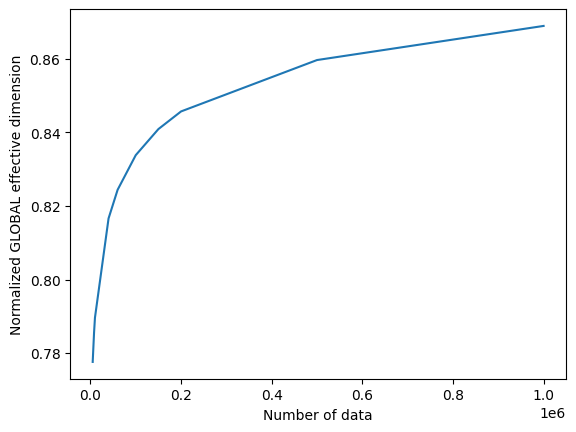

In [14]:
# plot the normalized effective dimension for the model
plt.plot(n, np.array(global_eff_dim_1) / d)
plt.xlabel("Number of data")
plt.ylabel("Normalized GLOBAL effective dimension")
plt.show()

# **Local Effective Dimension Example**

El algoritmo de dimensión efectiva local solo usa un conjunto de pesos y se puede usar para monitorear cómo el entrenamiento afecta la expresividad de una red neuronal.\
Comenzamos creando un conjunto de datos de clasificación binaria 3D utilizando la función make_classification de scikit-learn.

In [15]:
num_inputs = 3
num_samples = 50

X, y = make_classification(
    n_samples=num_samples,
    n_features=num_inputs,
    n_informative=3,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=2.0,
)
X = MinMaxScaler().fit_transform(X)
y = 2 * y - 1  # labels in {-1, 1}

El siguiente paso es crear una QNN, una instancia de EstimatorQNN en nuestro caso de la misma manera que creamos una instancia de SamplerQNN.

In [16]:
estimator_qnn = EstimatorQNN(circuit=qc)

4.2 Entrenar la QNN\
Ahora podemos proceder a entrenar la QNN. El paso de entrenamiento puede tomar algún tiempo, sé paciente.\
Puedes pasar una devolución de llamada al clasificador para observar cómo se desarrolla el proceso de entrenamiento.\
Fijamos initial_point con fines de reproducibilidad, como de costumbre.

In [17]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [18]:
# construct classifier
initial_point = algorithm_globals.random.random(estimator_qnn.num_weights)

estimator_classifier = NeuralNetworkClassifier(
    neural_network=estimator_qnn,
    optimizer=COBYLA(maxiter=80),
    initial_point=initial_point,
    callback=callback_graph,
)

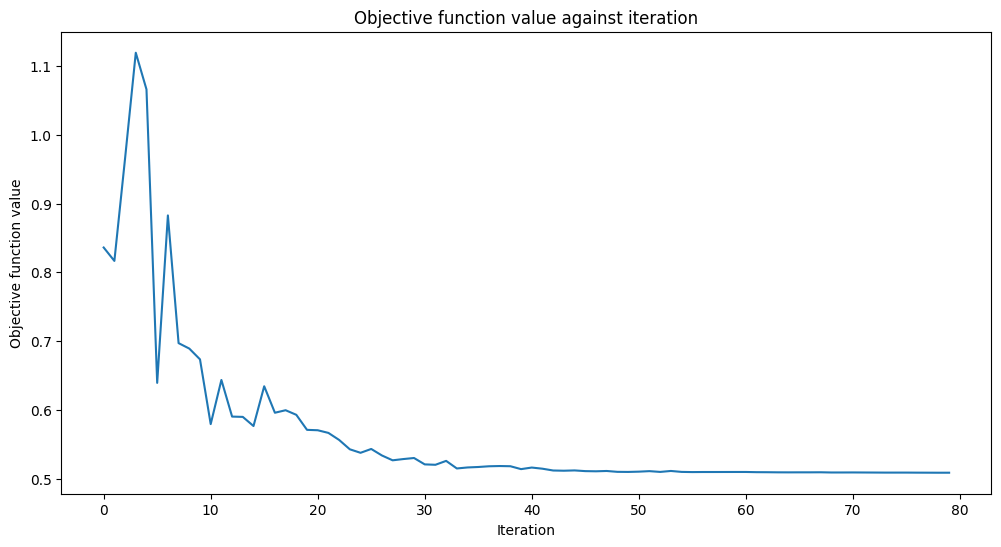

In [19]:
# create empty array for callback to store evaluations of the objective function (callback)
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

El clasificador ahora puede diferenciar entre clases con una precisión de:

In [20]:
# score classifier
estimator_classifier.score(X, y)

0.96

4.3 Calcular la Dimensión Efectiva Local de QNN entrenadas\
Ahora que hemos entrenado nuestra red, evaluemos la dimensión efectiva local en función de los pesos entrenados.\
Para ello accedemos a los pesos entrenados directamente desde el clasificador.

In [21]:
trained_weights = estimator_classifier.weights

# get Local Effective Dimension for set of trained weights
local_ed_trained = LocalEffectiveDimension(
    qnn=estimator_qnn, weight_samples=trained_weights, input_samples=X
)

local_eff_dim_trained = local_ed_trained.get_effective_dimension(dataset_size=n)

print(
    "normalized local effective dimensions for trained QNN: ",
    local_eff_dim_trained / estimator_qnn.num_weights,
)

normalized local effective dimensions for trained QNN:  [0.44341903 0.44722437 0.44935923 0.46652929 0.47280927 0.48155062
 0.48912321 0.49481234 0.51442235 0.5303734 ]


Un valor de dimensión efectiva normalizada de 0.51076948 sugiere que el modelo tiene una complejidad moderada. Este es un buen indicio de que el modelo puede tener una buena capacidad de generalización, pero siempre es importante confirmar esta suposición mediante evaluaciones adicionales en datos de prueba y técnicas de validación cruzada.

4.4 Calcular la Dimensión Efectiva Local de QNN no entrenadas\
Podemos comparar este resultado con la dimensión efectiva de la red no entrenada, usando el initial_point como nuestra muestra de peso:

In [22]:
# get Local Effective Dimension for set of untrained weights
local_ed_untrained = LocalEffectiveDimension(
    qnn=estimator_qnn, weight_samples=initial_point, input_samples=X
)

local_eff_dim_untrained = local_ed_untrained.get_effective_dimension(dataset_size=n)

print(
    "normalized local effective dimensions for untrained QNN: ",
    local_eff_dim_untrained / estimator_qnn.num_weights,
)

normalized local effective dimensions for untrained QNN:  [0.67099578 0.6843162  0.69074062 0.73063815 0.74192562 0.75562507
 0.76598077 0.77301326 0.79354765 0.807207  ]


En general, deberíamos esperar que el valor de la dimensión efectiva local disminuya después del entrenamiento. Esto se puede entender mirando hacia atrás en el objetivo principal del machine learning, que es elegir un modelo que sea lo suficientemente expresivo como para ajustarse a tus datos, pero no demasiado expresivo como para que se sobreajuste y funcione mal en nuevas muestras de datos.

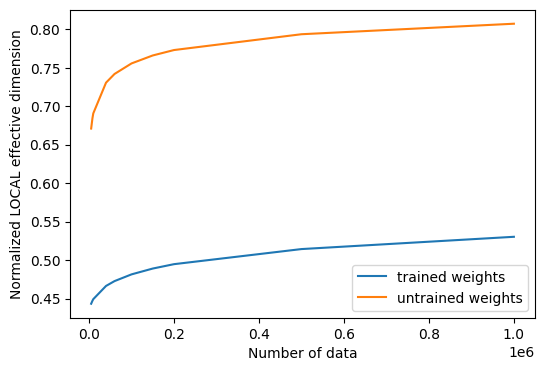

In [23]:
# plot the normalized effective dimension for the model
plt.plot(n, np.array(local_eff_dim_trained) / estimator_qnn.num_weights, label="trained weights")
plt.plot(
    n, np.array(local_eff_dim_untrained) / estimator_qnn.num_weights, label="untrained weights"
)

plt.xlabel("Number of data")
plt.ylabel("Normalized LOCAL effective dimension")
plt.legend()
plt.show()